# SatCen Change Detection using VRE processing service

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

This notebook produces a Change Detection analysis using the VRE processing service and publishes the results as a Research Object available on the SatCen VRE.

## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Sentinel-1 data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

## <a name="workflow">Workflow

#### Set the parameters

In [1]:
aoi_wkt = 'POLYGON((-3.611068725585937 40.57602136929037,-3.611068725585937 40.42669550575275,-3.4047317504882812 40.42669550575275,-3.4047317504882812 40.57602136929037,-3.611068725585937 40.57602136929037))'

In [2]:
polarization = 'VH'

In [3]:
date_of_interest = '2018-03-12'

#### Import the Python packages

In [4]:
import owslib
from owslib.wps import monitorExecution
import uuid
from owslib.wps import WebProcessingService
import sys
import os
sys.path.append('/opt/anaconda/bin/')
import lxml.etree as etree
os.environ["TMPDIR"] = '1'
os.environ["_CIOP_APPLICATION_PATH"] = '/'
import requests
import cioppy
ciop = cioppy.Cioppy()
import shapely
import dateutil.parser
from shapely.wkt import loads 
import pandas as pd
import geopandas as gp
from datetime import datetime, timedelta
from io import BytesIO
from zipfile import ZipFile
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np

%load_ext autoreload
%autoreload 2

#### Define a Sentinel-1 pairs search to identify the best master/slave

In [5]:
def pairs_search(slave, aoi, delta = 6):
    
    s1_osd = 'https://catalog.terradue.com/sentinel1/description'
    
    slave_search_params = dict([('uid', slave)])
    
    slave_search = ciop.search(end_point=s1_osd,
                         params=slave_search_params,
                         output_fields='identifier,productType,track,startdate,enddate,wkt',
                         model='EOP')
    
    master_search_params = dict([('geom', slave_search[0]['wkt']),
                           ('track', slave_search[0]['track']),
                            ('pt',slave_search[0]['productType']),
                            ('start', (dateutil.parser.parse(slave_search[0]['startdate']) - timedelta(days=delta +1)).isoformat()),
                            ('stop', (dateutil.parser.parse(slave_search[0]['enddate']) - timedelta(days=delta -1)).isoformat())])
    
    try:
        master_search = ciop.search(end_point=s1_osd, 
                            params=master_search_params,
                            output_fields='identifier,wkt,self',
                            model='EOP')
    except IndexError:
        return None
    
    slave_wkt = loads(slave_search[0]['wkt'])
    aoi = loads(aoi)

    result = []

    for index, elem in enumerate(master_search):
        
        master_search[index]['slave'] = slave
        master_search[index]['slave_wkt'] = slave_wkt
        master_wkt = loads(elem['wkt'])
        intersec=slave_wkt.intersection(master_wkt)
        master_search[index]['slave_master_intersec'] = (intersec.area/slave_wkt.area) * 100
        master_search[index]['slave_master_intersec_wkt'] = intersec
        
    
        if intersec.contains(aoi) or intersec.intersects(aoi):
            intersec_aoi = intersec.intersection(aoi)
            master_search[index]['aoi_intersec'] = (aoi.area/intersec_aoi.area) * 100
            master_search[index]['aoi_intersec_wkt'] = intersec_aoi
        else: 
            master_search[index]['aoi_intersec'] = -1
            master_search[index]['aoi_intersec_wkt'] = ''
    
        result.append({'master' : master_search[index]['identifier'],
                       'master_ref' : master_search[index]['self'],
                       'master_wkt': master_wkt,
                       'slave': slave,
                       'slave_wkt': slave_wkt,
                       'master_slave_intersec': slave_wkt,
                       'master_slave_intersec' : master_search[index]['slave_master_intersec'],
                       'slave_master_intersec_wkt' : master_search[index]['slave_master_intersec_wkt'],
                       'aoi_intersec': master_search[index]['aoi_intersec'],
                       'aoi_intersec_wkt': master_search[index]['aoi_intersec_wkt']})
        
    return gp.GeoDataFrame(result)

In [6]:
s1_osd = 'https://catalog.terradue.com/sentinel1/description'

In [7]:
slave_search_params = dict([('geom', aoi_wkt),
                            ('pt', 'GRD'),
                            ('q', 'GRHD'),
                            ('start', date_of_interest),
                            ('stop', date_of_interest)])

In [8]:
found_slave = False

slave_date = (dateutil.parser.parse(date_of_interest)).isoformat()

aoi = loads(aoi_wkt)

while not found_slave:
    print slave_date
    print (dateutil.parser.parse(slave_date) + timedelta(days=1) - timedelta(seconds=1)).isoformat()
    slave_search_params = dict([('geom', aoi_wkt),
                            ('pt', 'GRD'),
                            ('q', '*GRDH*'),
                            ('start', slave_date),
                            ('stop', (dateutil.parser.parse(slave_date) + timedelta(days=1) - timedelta(seconds=1)).isoformat())])
    
    try:
       
        slave_search = ciop.search(end_point=s1_osd, 
                            params=slave_search_params,
                            output_fields='identifier,wkt,self',
                            model='EOP', timeout = 500000)
        
        area = 0
        
        for index, elem in enumerate(slave_search):
            slave_wkt = loads(elem['wkt'])
            intersec_aoi = aoi.intersection(slave_wkt)
            
            print str((intersec_aoi.area / aoi.area) * 100)
            
            if (intersec_aoi.area / aoi.area) * 100 > area:
                area = (intersec_aoi.area / aoi.area)
                slave = elem
            
            
    except IndexError as e:
        print 'e' 
        slave_date = (dateutil.parser.parse(slave_date) + timedelta(days=1)).isoformat()
        continue
    else:
        print 'here'
        found_slave = True

2018-03-12T00:00:00
2018-03-12T23:59:59
5.01715329046
94.9408705609
100.0
here


Slave is:

In [9]:
slave['self']

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D'

In [10]:
pairs = pairs_search(slave['identifier'],
                      aoi_wkt,
                      24)

#### List the master candidates

In [11]:
pairs

aoi_intersec                                   aoi_intersec_wkt  \
0          -1.0                                                      
1         100.0  POLYGON ((-3.611068725585937 40.57602136929037...   
2          -1.0                                                      

                                              master  \
0  S1A_IW_GRDH_1SDV_20180216T061818_20180216T0618...   
1  S1A_IW_GRDH_1SDV_20180216T061753_20180216T0618...   
2  S1A_IW_GRDH_1SDV_20180216T061728_20180216T0617...   

                                          master_ref  master_slave_intersec  \
0  https://catalog.terradue.com/sentinel1/search?...               0.002845   
1  https://catalog.terradue.com/sentinel1/search?...              99.956103   
2  https://catalog.terradue.com/sentinel1/search?...               0.000000   

                                          master_wkt  \
0  POLYGON ((-2.320131 37.863132, -5.290902 38.27...   
1  POLYGON ((-1.943217 39.365131, -4.978655 39.77...   
2  POLYGON ((-1.569212 40.86797, -4.674003 41.276...   

                                               slave  \
0  S1A_IW_GRDH_1SDV_20180312T061753_20180312T0618...   
1  S1A_IW_GRDH_1SDV_20180312T061753_20180312T0618...   
2  S1A_IW_GRDH_1SDV_20180312T061753_20180312T0618...   

                           slave_master_intersec_wkt  \
0  POLYGON ((-1.943257099121058 39.36498381465393...   
1  POLYGON ((-4.977228752478204 39.77506029783111...   
2                                                 ()   

                                           slave_wkt  
0  POLYGON ((-1.942178 39.364838, -4.97725 39.774...  
1  POLYGON ((-1.942178 39.364838, -4.97725 39.774...  
2  POLYGON ((-1.942178 39.364838, -4.97725 39.774...

Select the master that covers the most the slave

In [12]:
index = pairs['master_slave_intersec'].idxmax()

In [13]:
gp.GeoDataFrame(pairs.iloc[index])

1
aoi_intersec                                                             100
aoi_intersec_wkt           POLYGON ((-3.611068725585937 40.57602136929037...
master                     S1A_IW_GRDH_1SDV_20180216T061753_20180216T0618...
master_ref                 https://catalog.terradue.com/sentinel1/search?...
master_slave_intersec                                                99.9561
master_wkt                 POLYGON ((-1.943217 39.365131, -4.978655 39.77...
slave                      S1A_IW_GRDH_1SDV_20180312T061753_20180312T0618...
slave_master_intersec_wkt  POLYGON ((-4.977228752478204 39.77506029783111...
slave_wkt                  POLYGON ((-1.942178 39.364838, -4.97725 39.774...

#### Select the master

In [14]:
master = pairs['master_ref'].iloc[index]

The master is:

In [15]:
master

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18'

Plot the slave/master and AOI

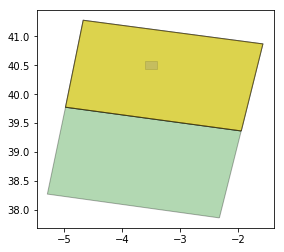

In [16]:
selected = gp.GeoDataFrame(pairs.iloc[:index+1])

fig, ax = plt.subplots()
ax.set_aspect('equal')

selected = selected.set_geometry('master_wkt')
selected.plot(ax=ax, color='green', edgecolor='black', alpha=0.3)

selected = selected.set_geometry('slave_wkt')
selected.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.3)

selected = selected.set_geometry('slave_master_intersec_wkt')
selected.plot(ax=ax, color='red', edgecolor='black', alpha=0.1)

selected = selected.set_geometry('aoi_intersec_wkt')
selected.plot(ax=ax, color='blue', edgecolor='black', alpha=0.1)

plt.show();

#### Prepare the processing request

In [17]:
wps_url = 'https://ec-everest-deployer.terradue.com/zoo-bin/zoo_loader.cgi'

In [18]:
wps = WebProcessingService(wps_url, verbose=False, skip_caps=True)

In [19]:
wps.getcapabilities()

#### List the processing services available

In [20]:
for index, elem in enumerate(wps.processes):
    print(index, elem.identifier)

(0, 'UnDeployProcess')
(1, 'DeployProcess')
(2, 'GetStatus')
(3, 'ec_everest_dcs_satcen_sentinel1_cd_workflow_1_1_8')


In [21]:
process_id = wps.processes[3].identifier

In [22]:
process_id

'ec_everest_dcs_satcen_sentinel1_cd_workflow_1_1_8'

In [23]:
process = wps.describeprocess(process_id)

In [24]:
process.title

'SatCen Change Detection Workflow'

In [25]:
process.abstract

'SatCen Change Detection Workflow'

#### Prepare the inputs

In [26]:
for input in process.dataInputs:
    print(input.identifier)

master
polygon
polarization
slave
_T2Username


In [27]:
master

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18'

In [28]:
slave['self']

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D'

In [29]:
inputs = [('master', master),
        ('slave', slave['self']),
        ('polarization', polarization),
        ('polygon', aoi_wkt),
        ('_T2Username', 'fbrito')]

#### Submit the processing request

In [30]:
wps = WebProcessingService(wps_url, verbose=False, skip_caps=True)

In [31]:
execution = owslib.wps.WPSExecution(url=wps.url)

In [32]:
execution_request = execution.buildRequest(process_id, 
                                           inputs, 
                                           output = [('result_osd', False)])

In [33]:
execution_response = execution.submitRequest(etree.tostring(execution_request))

In [34]:
execution.parseResponse(execution_response)

In [35]:
execution.statusLocation

'http://ec-everest-deployer.terradue.com/zoo-bin/zoo_loader.cgi?request=Execute&service=WPS&version=1.0.0&Identifier=GetStatus&DataInputs=sid=5a18154c-7892-11e8-b224-0242ac11000d&RawDataOutput=Result'

#### Monitor the processing and wait for its conclusion

In [36]:
monitorExecution(execution)

In [37]:
execution.isSucceded()

True

#### Get the outputs

In [38]:
for output in execution.processOutputs:
    print(output.identifier)

result_osd
QUOTATION


In [39]:
results_osd = execution.processOutputs[0].reference

In [40]:
search = ciop.search(end_point=results_osd,
                         params=[],
                         output_fields='identifier,enclosure',
                         model='GeoTime')

In [41]:
for index, elem in enumerate(search):
    print(elem['enclosure'])

https://store.terradue.com/fbrito/_results/workflows/ec_everest_dcs_satcen_sentinel1_cd_workflow_1_1_8/run/5a18154c-7892-11e8-b224-0242ac11000d/0003815-180330140554685-oozie-oozi-W/cd.tif


In [42]:
access_token = 'eyJ2ZXIiOiIyIiwidHlwIjoiSldUIiwiYWxnIjoiUlMyNTYiLCJraWQiOiJRdldZU0xtOGxiUzBmUUdaN1hrSktROXo3a3BPM1k2UU93cE5sNmkxc25vIn0.eyJzdWIiOiJqZnJ0QDAxYzlnbW5uM3MxcDRmMHBrMHA0eDkwZXkxXC91c2Vyc1wvZmJyaXRvIiwic2NwIjoibWVtYmVyLW9mLWdyb3Vwczpub2EtcmFkYXJzYXQyLndyaXRlcixvd3MxMy1lb2Mud3JpdGVyLGVjLW5leHRnZW9zcy5yZWFkZXIsY3JsLXJhZGFyc2F0Mi5yZWFkZXIsZWMtZWNvcG90ZW50aWFsLnJlYWRlcixub2EtY29zbW9za3ltZWQud3JpdGVyLG5vYS1lcnMud3JpdGVyLGNybC1jb3Ntb3NreW1lZC53cml0ZXIsZW52aXNhdC53cml0ZXIsb3dzMTMtZW9jLnJlYWRlcixIYWl0aVJPLXRzeC5yZWFkZXIsc3BvdC03LnJlYWRlcixzcG90LTYucmVhZGVyLG5vYS10ZXJyYXNhci14LndyaXRlcixlbGxpcC1oYXJ2ZXN0aW5nLnJlYWRlcixub2EtdGVycmFzYXIteC5yZWFkZXIsZS1sZWFybmluZy53cml0ZXIsZWMtYmV0dGVyLnJlYWRlcixzcG90LTcud3JpdGVyLGVvLXNhbXBsZXMud3JpdGVyLG5vYS1lcnMucmVhZGVyLHNwb3QtNi53cml0ZXIsc3RhZmYsZWxsaXAtY2FjaGluZy5yZWFkZXIsZWMtZXZlcmVzdC5yZWFkZXIsY2FjaGUud3JpdGVycyxjcmwtcmFkYXJzYXQyLndyaXRlcixyZWFkZXJzLG5vYS1yYWRhcnNhdDIucmVhZGVyLGNhY2hlLnJlYWRlcnMsZmJyaXRvLm93bmVyLG5vYS1jb3Ntb3NreW1lZC5yZWFkZXIsY3JsLWNvc21vc2t5bWVkLnJlYWRlciBhcGk6KiIsImF1ZCI6ImpmcnRAMDFjOWdtbm4zczFwNGYwcGswcDR4OTBleTEiLCJpc3MiOiJqZnJ0QDAxYzlnbW5uM3MxcDRmMHBrMHA0eDkwZXkxIiwiZXhwIjoxNTIzOTU2MTk1LCJpYXQiOjE1MjM5NTI1OTUsImp0aSI6IjE0MzZmOGVjLThlMDAtNGM3NC04YTNhLTYxODk2MjMxOTExMCJ9.LW5N4-OHMWLRRCB22xbPlRgFuM7ctnTk2_5JViyZ-Y_tngb6_mMT_tFJlAN8HhpmAElJYJ5l0SVA1PHd233U408D4TsT4T9QI4tDrgLnvJl4k8z6V6Koow4LD2nuDEjcH3QXxEl6iHu8lFe8ZjWBxuwGtJg-k252sAw7RT0U6r2kazVuAI2rjzKPoi0Z3kinEVjqkWYQMzL0fg2qZDiq46kyuQsi3xMSJ6iJt2HcbQl_vAp0_srmAas35Ch0nfXtni9sTXPPvRhR4PGwsreOm95ZbKANTqW1VAuDKvizHqXnAosul6nrwCX5JgBgn1jQdQzuH4SmmI1E6foLenqFhQ'

In [43]:
headers = {'Authorization': 'Bearer %s' % access_token}

In [44]:
r = requests.get(search[0]['enclosure'], headers=headers)

In [45]:
r.request.body


In [46]:
output_dir="/workspace/data/outputs/13_satcen_change_detection_using_vre_processing_service"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
    
open(output_dir + '/cd.tgz', 'wb').write(r.content)

#### Create a Research Object

Get an EVER-EST Single-Sign-On token from https://sso.everest.psnc.pl/authenticationendpoint/getTokenLogin.html 

In [47]:
token = '21dc9abb-30c6-36b1-a2db-2770922f8058'

In [48]:
ro_title = 'SatCen Change Detection over Madrid'
ro_description = 'This is the result of the SatCen Change Detection service of the EVER-EST VRC for Land Monitoring'
ro_vrc = 'SatCen'

In [49]:
sys.path.append(os.getcwd())
import ro4eo

In [50]:
roeo = ro4eo.EOResearchObject(access_token=token,
                       title=ro_title,
                       description=ro_description,
                       vrc=ro_vrc,
                       aoi=aoi_wkt)

In [51]:
roeo.isTokenValid()

False

In [52]:
roeo.add_resource(master)
roeo.add_resource(slave)
roeo.add_result('cd.tgz')

In [ ]:
ro = roeo.publish()

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.